# Get Libraries

In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print('tf-version: ', tf.__version__)

# my plot function for confusion matrix
def plot_cm(mat):
  classes = np.arange(cm.shape[0])
  plt.imshow(mat, cmap=plt.cm.Blues)
  for (j,i),label in np.ndenumerate(mat):
    plt.text(i,j,np.round(label,2),ha='center',va='center')

  plt.colorbar()
  plt.title('Confusion Matrix')
  plt.xlabel('True label')
  plt.ylabel('Pred label')
  plt.xticks(classes)
  plt.yticks(classes)
  plt.show()

tf-version:  2.4.1


# Challenges from previous work (MNIST)






<div>
   <img src="https://github.com/thomasmanke/ABS/raw/main/figures/smileys.png",  width="500">
</div>

- training (and test) data were highly structured: fixed size, grey scale, item centered, only single item 

**Discussion**: other possible challenges?

- spatially distributed features
- view point
- illumination
- deformation
- occlusion 
- intraclass variation

Algorithms should be 

- robuts to those changes within one class (e.g. cat)
- generic and transferable to all other classes 
- interpretable

# A short history

Algorithms, Compute Power, Data, Data & Data

- 1958 Rosenblatt: The perceptron: A probabilistic Model for Information Storage and  Organization in the Brain.
- 1998 Le Cun et al.  (MNIST):  60000 images of 10 handwritten digits ($10^7$ pixels) + CPU ($10^6$ transitors)
- 2012 Alex Krizhevsky et al (ImageNet): 1.3M images for 1000 classes ($10^{14}$ pixels) + GPU ($10^9$ transistors)
- 2021 Yang et al. (MedMNIST): 700k images for 2-11 classes 
https://github.com/MedMNIST/MedMNIST
- 2022 Google Open Images v6: 60M images, 20000 classes: https://storage.googleapis.com/openimages/web/index.html



# Another classical dataset: CIFAR-10

This is a set of 50k images in 10 categories.
They are rather coarse (32 x 32), but unlike MNIST and MNIST-Fashion they are not as standardized.



In [5]:
# cell takes 1-2 minutes (on my regular home network)
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### downsampling to avoid kernel crashes with small RAM (e.g Binder)
n_down = 10000
n_down_test = int(n_down/5)

if (n_down>0):
  np.random.seed(42)
  print('train-before:', X_train.shape, y_train.shape)
  print('test-before: ', X_test.shape, y_test.shape)
  id_train = np.random.choice(X_train.shape[0],n_down)
  id_test  = np.random.choice(X_test.shape[0],n_down_test)
  X_train, y_train = X_train[id_train, ...], y_train[id_train, ...]
  X_test, y_test = X_test[id_test, ...], y_test[id_test, ...]
  print('train-before:', X_train.shape, y_train.shape)
  print('test-before: ', X_test.shape, y_test.shape)

# normalization
X_train, X_test = X_train / 255.0, X_test / 255.0

# just for easier reference to replace integers with names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

train-before: (50000, 32, 32, 3) (50000, 1)
test-before:  (10000, 32, 32, 3) (10000, 1)
train-before: (10000, 32, 32, 3) (10000, 1)
test-before:  (2000, 32, 32, 3) (2000, 1)


# Group Task (40 min):  Explore, Model, Fit, Evaluate


## Explore

In [ ]:
%%script echo edit before running
... Data Exploration ...
... shapes etc . ...

## Repeat: Try a Simple Neural Network

... you might copy the model with one dense layer from the handwritten digits example.

In [1]:
%%script echo define model here

model.summary()

define model here


## Fit

Fit model for 20 epochs. Afterwards save the model and the metrics history.

RAM limitations? 

This has been tested on mybinder.org (with 2GB RAM) but if RAM should still be limited you may have to downsample the data further (see above) and/or use smaller batch sizes (16) here.

In [ ]:
fh = mod1.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size= 32, verbose=0)

model_fn   = 'cifar_model_1.h5'  
history_fn = 'cifar_history_1.npy'
mod1.save(model_fn)
np.save(history_fn, fh) 

INFO:tensorflow:Assets written to: ram://2c555f0f-f879-4330-bc78-19c58e13ca75/assets


## Evaluation and Predictions

63/63 [==============================] - 0s 3ms/step - loss: 1.8961 - sparse_categorical_accuracy: 0.3765


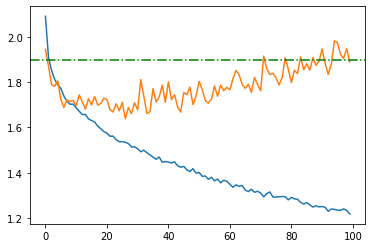

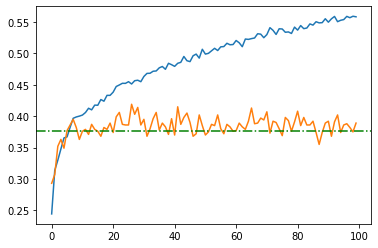

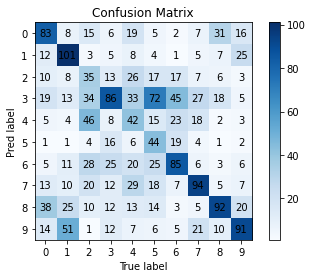

In [ ]:
test_loss, test_acc = mod1.evaluate(X_test, y_test)

a_name='sparse_categorical_accuracy'
val_a_name = 'val_' + a_name
plt.plot(fh.history['loss'])
plt.plot(fh.history['val_loss'])
plt.axhline(y=test_loss, color='green', linestyle='-.',label = 'test')
plt.show()

plt.plot(fh.history[a_name])
plt.plot(fh.history[val_a_name])
plt.axhline(y=test_acc, color='green', linestyle='-.',label = 'test')
plt.show()

mod1_pred = mod1.predict(X_test)           # probabilities    
y_pred    = np.argmax(mod1_pred, axis=1)   # classes with max prob (= labels)
cm=confusion_matrix(y_pred, y_test)
plot_cm(cm)

**Message:**

There are several ways to improve this (more data, hyperparameters etc.)

However, achieving higher (test and valdiation) accuracy on flattened images will generally be difficult $\to$ change network architecture


# Convolutional Neural Networks (CNN)
... a picture and some jargon

![CNN_convlayer](https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png)
(from wikipedia.org)

## New layers: Filters and Pools

![filter](https://wiki.tum.de/download/attachments/23572254/cnn6.png)
(from wiki.tum.de)

- **input layer:** image shape [width, height, 3 (RGB)]
- **convolutional layer** (Conv): n filters e.g (n,3,3,3)

  - detect pattern (e.g. horizontal, vertical, diagonal lines)
  - have the same depth as input
  - several filter per layer: different filters applied to same spatial location in image

- **pooling filter** (Pool)
  - spatially downsampling, depth stay the same (e.g. max or average)

- **fully conncted layer** (Dense)
  - connect all previous nodes

Typical structures: Input - Conv/Relu - Conv/Relu - Pool - Conv/Relu - ... - Dense

Lower layers: Primitive "concepts",  Higher layers: Higher order "concepts" 


# CNN: tensorflow implementation

In [44]:
nc = np.unique(y_train).size  # number of classes / labels in training set
l_name = 'sparse_categorical_crossentropy'
a_name = 'sparse_categorical_accuracy'

input_shape = X_train.shape[1:]

print('X_train.shape:     ', X_train.shape)
print('input_shape:       ', input_shape)
print('number of classes: ', nc)

model = tf.keras.models.Sequential(name='cifar_CNN_4')

# Convolutional layers
model.add(tf.keras.layers.InputLayer(input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='1st_conv'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# an additional layer
#model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='2nd_conv'))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# as before
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', name='last'))
model.add(tf.keras.layers.Dense(nc, activation='softmax', name='output'))

model.compile(optimizer='adam', loss=l_name, metrics=a_name)
model.summary()

X_train.shape:      (10000, 32, 32, 3)
input_shape:        (32, 32, 3)
number of classes:  10
Model: "cifar_CNN_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_conv (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0         
_________________________________________________________________
last (Dense)                 (None, 128)               1843328   
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,846,410
Trainable params: 1,846,410
Non-trainable params: 0
_________________________________________________________________


## CNN: fitting, GPUs and batch size

The following cell will fit the model. This will take some time - especially without dedicated hardware (e.g. GPU) or further optimization (improved algorithm).

Alternatively you can obtain the model from the github directory and load it without learning (see instructions below)



In [45]:
fh = model.fit(X_train, y_train, epochs=33, batch_size=64, validation_split=0.1, verbose=0)

model_fn   = model.name + '.h5'  
history_fn = model.name + '_history.npy'


In [46]:
model.save(model_fn)
np.save(history_fn, fh.history)

## Loading Model and History

If the learning above takes too much time you may also obtain the trained model and metric history from the github data/ directory and load it here.

In [47]:
#%%script echo Run after new start
model_fn   = 'cifar_CNN_4.h5'
history_fn = 'cifar_CNN_4_history.npy'

model = tf.keras.models.load_model(model_fn)
fh = np.load(history_fn, allow_pickle=True).item()

# For the following to work you also need to load+normalize the test_data !!!!

## Evaluations

63/63 [==============================] - 5s 59ms/step - loss: 2.7669 - sparse_categorical_accuracy: 0.5495


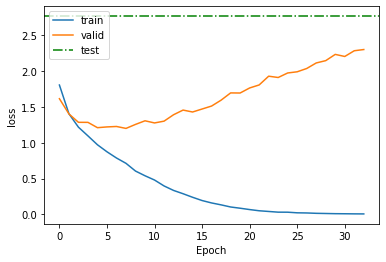

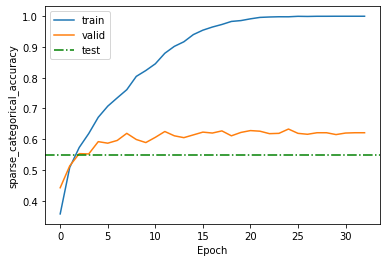

In [48]:
#%%script echo evaluate the model
## Plotting history and test accuracy
def plot_fit_history(fh, name='loss', test_score=0):
  """Plots history of metrics 'name'
  The validation metrics will also be plotted if available as 'val_name' (Keras convention)
  A test_score can be added to compare the evolution"""

  if name not in fh:
      print('plot_fit_history: {} is not a key in history !'.format(name))
      return
  val_name = 'val_' + name
  plt.plot(fh[name],     label='train')

  if val_name in fh:
    # add validation if in data
    plt.plot(fh[val_name], label='valid')
  
  plt.axhline(y=test_score, color='green', linestyle='-.',label = 'test')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend(loc='upper left')
  plt.show()

    
    
    
test_loss, test_acc = model.evaluate(X_test, y_test)

a_name='sparse_categorical_accuracy'
plot_fit_history(fh, 'loss', test_loss)
plot_fit_history(fh, a_name, test_acc)

**Message:** An improvement over the previous network.

**Discussion:** What could be further improvements?

## Group Task (20 min): Predictions

Explore individual predictions for test data

(32, 32, 3)


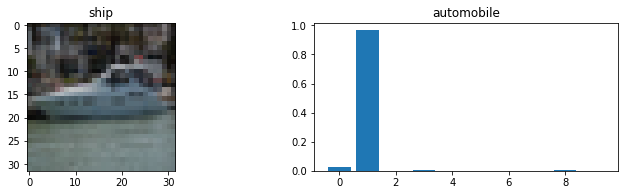

In [49]:
#%%script echo chose an index of your choice
idx=7
X = X_test[idx]
print(X.shape)
X = np.expand_dims(X, axis=0)  #this all is synonymous to X_test[idx:idx+1,:,:,:]

pred = model.predict(X)
i_max=np.argmax(pred)
true_lab=class_names[y_test[idx][0]]
pred_lab=class_names[i_max]

plt.figure(figsize=(12,6))
ax = plt.subplot(2,2,1)
plt.imshow(X_test[idx]) 
plt.title(true_lab)

ax = plt.subplot(2,2,2)
plt.bar(range(10), pred[0])
plt.title(pred_lab)
plt.show()

Compare all predictions with ground truth for test data

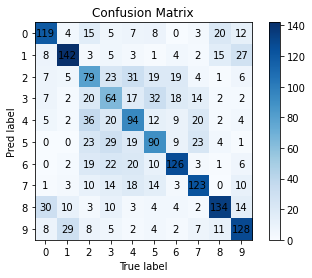

In [50]:
model_pred = model.predict(X_test)          # probabilities    
y_pred    = np.argmax(model_pred, axis=1)   # classes with max prob (= labels)
cm=confusion_matrix(y_pred, y_test)
plot_cm(cm)

# A closer look at layers

Motivation: Understand prediction in terms of layered "concepts"

In [ ]:
model.summary()

## Filters

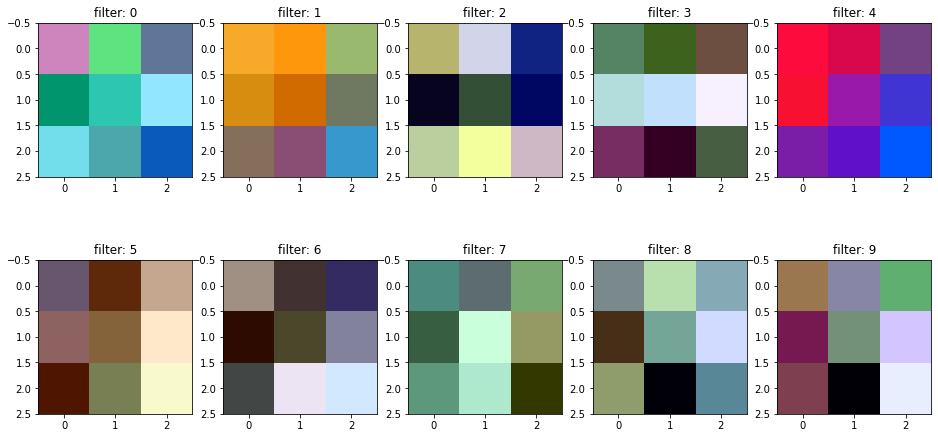

In [ ]:
layer_name='first_conv'
W,b = model.get_layer(layer_name).get_weights()  # by name
# W,b = model.layers[0].get_weights()            # by index

fig = plt.figure(figsize=(16, 8))
nr, nc = (2,5)                    # define number of rows and columns
for i in range(0, nr*nc):
    img = W[:,:,:,i]                                      # each filter has 3D
    img = (img - img.min()) / (img.max() - img.min())     # scale -> [0,1]
    fig.add_subplot(nr, nc, i+1)
    plt.imshow(img)
    plt.title('filter: {}'.format(i))

plt.show()

**Notice:** Maximal activation for all RGB channels=1 (black) and minimal activation for all RGB channels = 0 (white)

## The last layer

The goal of the added convolutional layers is to obtain a better representation of the image data by representing spatial features (edges etc.). If this is successful then we would expect better separation properties in the penultimate layer (last before output layer).

In [ ]:
model.summary()

Model: "cifar_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_conv (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 last (Dense)                (None, 128)               921728    
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 923,914
Trainable params: 923,914
Non-trainable params: 0
___________________________________________________

X shapes:  (1000, 3072) (1000, 128)
PCA Shapes:  (1000, 2) (1000, 2)


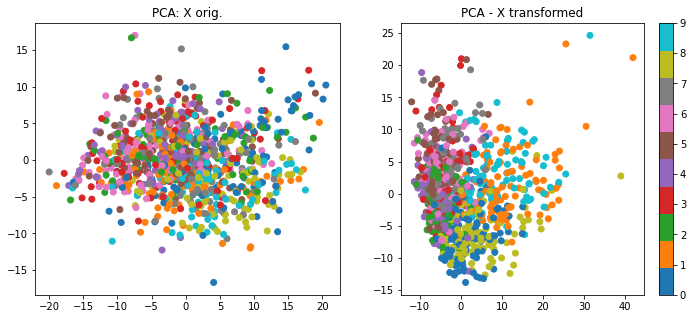

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# define new model: X -> last layer
layer_name = 'last'
layer_model = tf.keras.Model(inputs=model.input,
                             outputs=model.get_layer(layer_name).output)

nr = 1000
y=y_train[:nr]
X=X_train[:nr]
X_lay = layer_model(X).numpy()   # last layer representation of X

X = X.reshape(nr,-1)                # flatten each image
X_lay = X_lay.reshape(nr,-1)        # flatten each image (redundant)

print('X shapes: ',X.shape, X_lay.shape)

#X_pca = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
#X_lay_pca = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_lay)

X_pca = PCA(n_components = 2).fit_transform(X)
X_lay_pca = PCA(n_components = 2).fit_transform(X_lay)
print('PCA Shapes: ',X_pca.shape, X_lay_pca.shape)

plt.figure(figsize=(12, 5))
cm = plt.get_cmap('tab10')

ax = plt.subplot(1, 2, 1)
plt.scatter( X_pca[:,0], X_pca[:,1] , c=y, cmap=cm)
plt.title('PCA: X orig.')

ax = plt.subplot(1, 2, 2)
plt.scatter( X_lay_pca[:,0], X_lay_pca[:,1] , c=y, cmap=cm)
plt.title('PCA - X transformed')

plt.colorbar()
plt.show()